# Система автоматизированного подбора тарифа для оператора мобильной связи «Мегалайн»

    
## Цель: предсказать, использует ли пользователь тариф "Ультра" 
## Данные

|Наименование|Описание|
|----|----|
|calls|количество звонков|
|minutes|суммарная длительность звонков в минутах|
|messages|количество sms-сообщений|
|mb_used|израсходованный интернет-трафик в Мб|
|is_ultra|каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)|

## Этапы исследования
    
[1. Откройте файл с данными и изучите его. Путь к файлу: datasets/users_behavior.csv](#_1_1112) 
    
* [типы данных](#_1_1_1112) 
    
* [пропуски в данных](#_1_2_1112) 
    
* [выбросы/распределения](#_1_3_1112) 
    
[2. Разделите исходные данные на обучающую, валидационную и тестовую выборки.](#_2_1112) 
    
[3. Исследуйте качество разных моделей, меняя гиперпараметры. Кратко напишите выводы исследования. Проверьте качество модели на тестовой выборке.](#_3_1112)  
    
## Выводы
    
* доля людей с тарифом "Ультра" составляет примерно 30% --> для валидации спользовался StratifiedkFold
* выявленные аномалии не являются выбросами или ошибками, они характеризуют особенности пользователей тарифов
* в данных нет пропущенных значений
* точность на валидации, точность на тесте (до и поcле подбора параметров)
* оптимальные параметры
    
1) Логистическая регрессия {'C': 5.0941380148163754e-05}
    
2) Дерево решений {'criterion': 'entropy', 'max_depth': 6}
    
3) Случайный лес {'max_depth': 8, 'max_features': 0.3, 'min_samples_leaf': 2, 'n_estimators': 100}
    
4) Бустинг (catboost) {'depth': 7, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.03}
    
5) Бустинг (sklearn) {'learning_rate': 0.03, 'max_depth': 4, 'min_samples_leaf': 2, 'n_estimators': 100, 'subsample': 0.7}
    
6) Бустинг (lightgbm) {'learning_rate': 0.1, 'max_depth': 20, 'min_data_in_leaf': 10, 'n_estimators': 100, 'num_leaves': 16}
    
|модель|валидация|отложенная|оптимальные_параметры_валидация|оптимальные_параметры_отложенная|
|---|---|---|---|---|
|Бустинг (sklearn)|0.807|0.809|0.808|0.82|
|Бустинг (catboost)|0.808|0.821|0.811|0.818|
|Бустинг (lightgbm)|0.796|0.807|0.806|0.813|
|Случайный лес|0.802|0.809|0.808|0.81|
|Дерево решений|0.741|0.728|0.793|0.792|
|Логистическая регрессия|.737|0.726|0.746|0.745|
|самый популярный класс|0.694|0.694|nan|nan|    
    
* финальная модель 

GradientBoostingClassifier()
    
параметры == {'learning_rate': 0.04,
             'max_depth': 4,
             'min_samples_leaf': 3,
             'n_estimators': 100}

валидация == 0.8082399607117223
    
тест == 0.8258164852255054)
    
признаки == число_звонков, число_сообщений, объем_трафика   
    
* логистическая регрессия обучается быстрее всего и дает стабильный скор на валидации и тесте
* дерево решений также дает одинаковый скор на тесте и валидации, требует подбора параметров
* случайный лес хорошо работает "из коробки"
* на валидации лучшаямодель- Catboost, на отложенной-GradientBoostingClassifier
* как финальную модель выберем GradientBoostingClassifier, так как она показывает лучший скор на данных, которые не видела
    
----------------------------------------------    

<a id='_1_1112'></a>

#### Откройте файл с данными и изучите его. Путь к файлу: datasets/users_behavior.csv

* подгружаем библиотеки

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib._color_data as mcd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook
from collections import defaultdict

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate
from itertools import combinations
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import time
import random

In [2]:
def _load_data(PATH_TO_FILE):
    ''' Загружает данные '''
    try:
        df = pd.read_csv(PATH_TO_FILE)
        return df
    except:
        try:
            df = pd.read_csv('/'+PATH_TO_FILE)
            return df
        except:
            raise ValueError('Неправильно задан путь к файлу')

In [3]:
# путь к файлу
PATH_TO_FILE = 'datasets/users_behavior.csv'

# генератор случайных чисел
SEED = 13

# фиксируем сид
random.seed(SEED)
np.random.seed(SEED)

* загружаем данные

In [4]:
# загружаем данные
df=_load_data(PATH_TO_FILE)

In [5]:
# меняем названия колонок
df.rename(columns = {'calls': 'число_звонков', 'minutes':'длина_звонков',\
                     'messages':'число_сообщений', 'mb_used':'объем_трафика', 'is_ultra' :'тариф_ультра'},\
          inplace = True)

* типы данных

<a id='_1_1_1112'></a>

In [6]:
# меняем названия колонок
df.rename(columns = {'calls': 'число_звонков', 'minutes':'длина_звонков',\
                     'messages':'число_сообщений', 'mb_used':'объем_трафика', 'is_ultra' :'тариф_ультра'},\
          inplace = True)

In [7]:
# целевой признак
target_col = 'тариф_ультра'

# признаки, целевая метка
X, y = df.drop(target_col, 1), df[target_col]

* отсутствующие значения

<a id='_1_2_1112'></a>

In [8]:
print('\t\tПропуски в данных\n----------------------------------------------')
for k, v in X.isna().sum().items():
    print('в {} --> {} пропущенных значений'.format(k, v))

		Пропуски в данных
----------------------------------------------
в число_звонков --> 0 пропущенных значений
в длина_звонков --> 0 пропущенных значений
в число_сообщений --> 0 пропущенных значений
в объем_трафика --> 0 пропущенных значений


* поиск ошибок/аномалий

In [9]:
X.agg({'min', 'max'}).T.rename(columns = {'min' :'минимум', 'max':'максимум'})

,максимум,минимум
число_звонков,244.00,0.0
длина_звонков,1632.06,0.0
число_сообщений,224.00,0.0
объем_трафика,49745.73,0.0


* число сообщений сильно скошено
* статистические тесты и модели обычно требуют нормальное распределение(попробуем его добиться) 

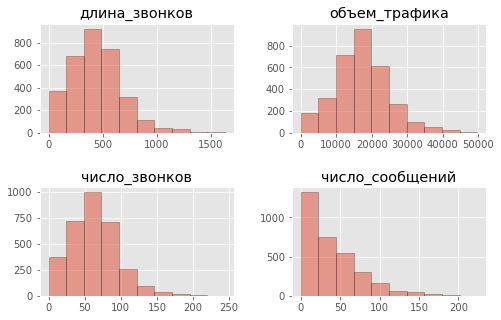

In [10]:
X.hist(edgecolor = 'black', alpha = .5, figsize = (8, 5))
plt.subplots_adjust(hspace = .5)

In [11]:
def _test_normality(feature, alpha):
    ''' Проверяет гиоптезу H0 - распределение другое(H1-нормальное) на уровне значимости alpha'''
    res = stats.normaltest(feature)[1] < alpha    
    if res:
        return 'Распределение другое на уровне значимости {:.0%}'.format(1-alpha)
    else:
        return 'Распределение нормальное на уровне значимости {:.0%}'.format(1-alpha)

<a id='_1_3_1112'></a>

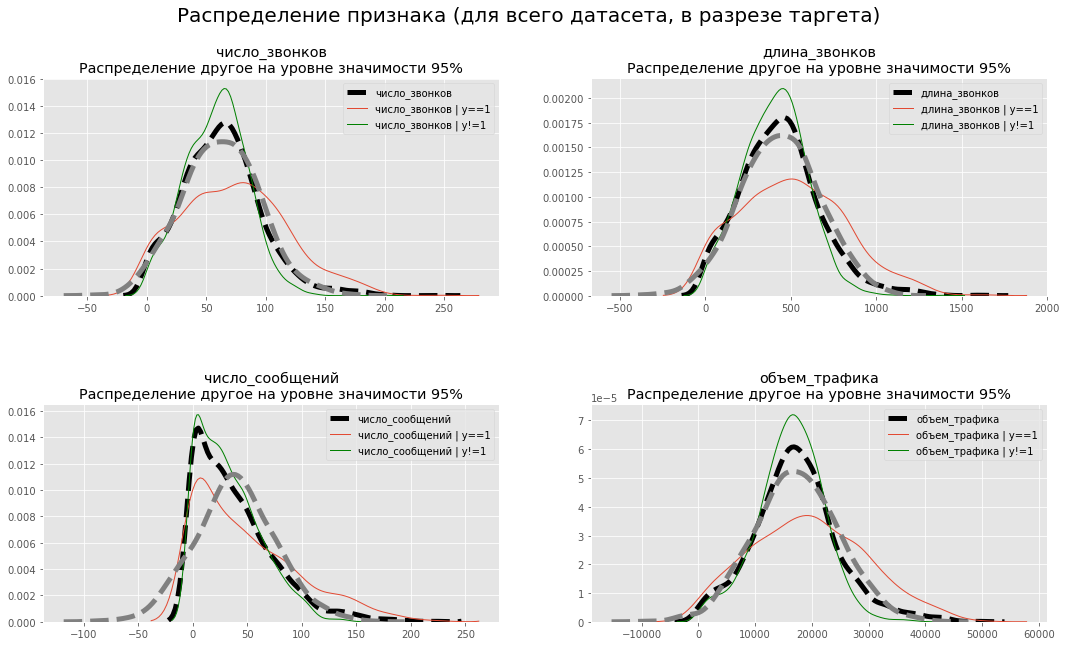

In [12]:
plt.figure(figsize = (18, 10))
plt.suptitle('Распределение признака (для всего датасета, в разрезе таргета)', fontsize = 20)
for idx, col in enumerate(X.columns):
    feature = X[col]  
    rv = stats.norm.rvs(feature.mean(), feature.std(), 1000)
    res = _test_normality(feature, alpha = .05)
    plt.subplot(2, 2, idx+1)
    sns.kdeplot(feature, color = 'black', linestyle = '--', linewidth = 5)
    sns.kdeplot(feature[y==1], linewidth = 1)
    sns.kdeplot(feature[y!=1], linewidth = 1, color ='green')
    sns.kdeplot(rv, color = 'grey', linestyle = '--', linewidth = 5)
    plt.legend([f'{col}', f'{col} | y==1', f'{col} | y!=1', 'нормальное'])
    plt.title(col+'\n'+res)
plt.subplots_adjust(hspace = .5)

* удаляем выбросы

In [13]:
def _exclude_outliers(series):
    q25, q75 = series.quantile([.25, .75])
    iqr = q75-q25
    return (series<q25-1.5*iqr)|(series>q75+1.5*iqr)

In [14]:
X_no_outliers = X[~X.apply(_exclude_outliers).any(1)]
y_no_outliers = y.loc[X_no_outliers.index]
print('Датасет без выбросов составляет {:.0%} от исходного датасета'.format(len(X_no_outliers)/len(X)))

Датасет без выбросов составляет 94% от исходного датасета


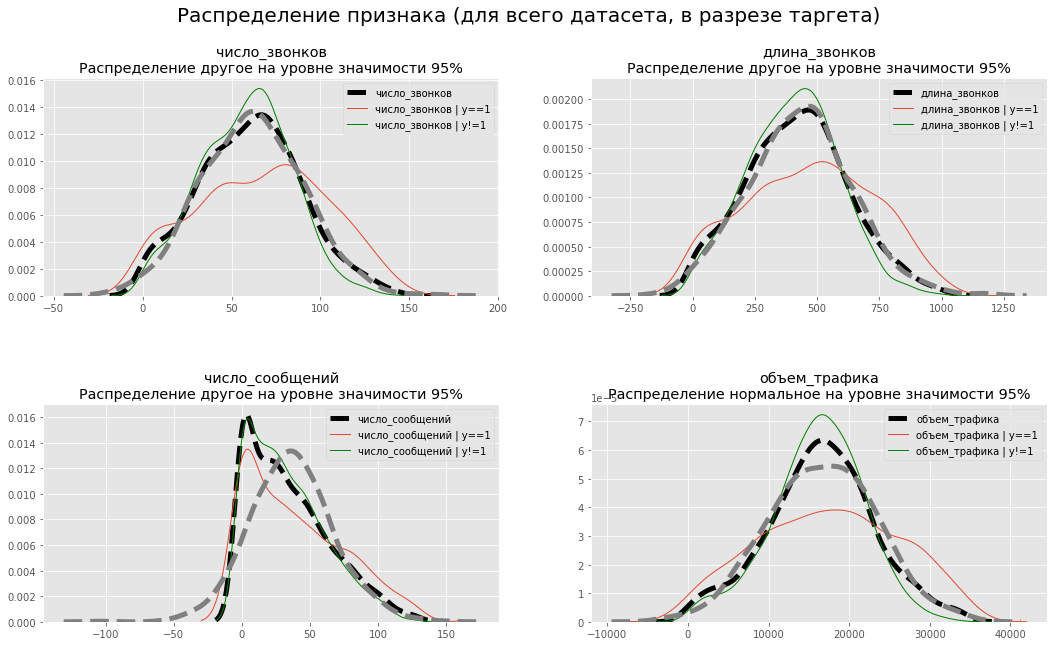

In [15]:
plt.figure(figsize = (18, 10))
plt.suptitle('Распределение признака (для всего датасета, в разрезе таргета)', fontsize = 20)
for idx, col in enumerate(X_no_outliers.columns):
    feature = X_no_outliers[col]  
    rv = stats.norm.rvs(feature.mean(), feature.std(), 1000)
    res = _test_normality(feature, alpha = .05)
    plt.subplot(2, 2, idx+1)
    sns.kdeplot(feature, color = 'black', linestyle = '--', linewidth = 5)
    sns.kdeplot(feature[y_no_outliers==1], linewidth = 1)
    sns.kdeplot(feature[y_no_outliers!=1], linewidth = 1, color ='green')
    sns.kdeplot(rv, color = 'grey', linestyle = '--', linewidth = 5)
    plt.legend([f'{col}', f'{col} | y==1', f'{col} | y!=1', 'нормальное'])
    plt.title(col+'\n'+res)
plt.subplots_adjust(hspace = .5)

<div class="alert alert-block alert-info">
аномально большие значения свойственны пользователям с тарифом "Ультра". удалять выбросы не будем, логарифмировать тоже
</div>


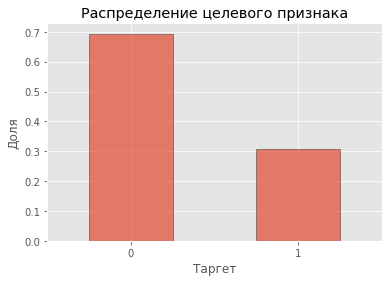

In [16]:
y_plot = y.value_counts(normalize =True).plot(kind = 'bar', alpha = .7, edgecolor = 'black')
y_plot.set_xticklabels(y_plot.get_xticklabels(), rotation = 0)
plt.xlabel('Таргет')
plt.ylabel('Доля')
plt.title('Распределение целевого признака')
plt.show()

<div class="alert alert-block alert-info">
пользователей с тарифом 'Ултра' примерно в 2 раза меньше пользователей с тарифом 'Смарт'. Будем использовать стратифицированное разбиение при валидации
</div>


<a id='_2_1112'></a>

#### Разделите исходные данные на обучающую, валидационную и тестовую выборки.

In [17]:
def _get_val_holdout_subsets(X, y, test_share, stratified, cv_strat, SEED):
    
    # numpy массивы
    _X, _y = np.array(X), np.array(y)
    
    # трейн, тест части
    if stratified:
        _X_tr, _X_te, _y_tr, _y_te = train_test_split(_X,_y,test_size = test_share, stratify=_y, random_state = SEED)       
    else:
        _X_tr, _X_te, _y_tr, _y_te = train_test_split(_X,_y, test_size = test_share, random_state = SEED)
        
     
    # фолды для валидации
    folds = []
    try:
        for tr_idx, val_idx in cv_strat.split(_X_tr, _y_tr):
            folds.append((tr_idx, val_idx))
    except:
        for tr_idx, val_idx in cv_strat.split(_X_tr):
            folds.append((tr_idx, val_idx))
            
    return (_X_tr, _X_te, _y_tr, _y_te, folds)
        
        

In [18]:
skf5 = StratifiedKFold(5, random_state = SEED)
_X_tr, _X_te, _y_tr, _y_te, folds = _get_val_holdout_subsets(X, y,\
                                                             test_share = .2, stratified = True,\
                                                             cv_strat = skf5, SEED = SEED)

#### Исследуйте качество разных моделей, меняя гиперпараметры. Кратко напишите выводы исследования.
* для каждой модели отбираем признаки с применением выбранного типа валидации


In [24]:
models_dict = {'Логистическая регрессия' : LogisticRegression(random_state = SEED),\
               'Дерево решений' : DecisionTreeClassifier(random_state = SEED),\
               'Случайный лес' : RandomForestClassifier(random_state = SEED),\
               'Бустинг (sklearn)' : GradientBoostingClassifier(random_state = SEED),\
               'Бустинг (lightgbm)' : LGBMClassifier(random_state = SEED),\
               'Бустинг (catboost)' : CatBoostClassifier(random_seed = SEED, silent = True)}
best_fs = {}
D_best_params = {}

In [27]:
AB_scores = pd.DataFrame(columns = ['валидация', 'отложенная'])
dummy_predictions = np.repeat(y.value_counts().idxmax(), len(y))
AB_scores.loc['самый популярный класс', :] = accuracy_score(y, dummy_predictions)

# проходим по моделям
for model_name, model in tqdm_notebook(models_dict.items()):
    best_cv_score = .5
    n_feat = _X_tr.shape[1]
    # перебирая все комбинации признаков, находим лучшие из них(по валидации)
    for combo_len in tqdm_notebook(range(1, n_feat+1)):
        for combo in combinations(range(n_feat), combo_len):
            idxs = list(combo) 
            if len(idxs) == 1:
                _X_tr2, _X_te2 = _X_tr[:, idxs].reshape(-1,1), _X_te[:, idxs].reshape(-1,1)
            else:
                _X_tr2, _X_te2 = _X_tr[:, idxs], _X_te[:, idxs]                
            model.fit(_X_tr2, _y_tr)
            y_pred = model.predict(_X_te2)
            _acc_holdout = accuracy_score(_y_te, y_pred)            
            scores = []
            for tr_idx, val_idx in folds:
                xtr, xval = _X_tr2[tr_idx], _X_tr2[val_idx]
                ytr, yval = _y_tr[tr_idx], _y_tr[val_idx]
                model.fit(xtr, ytr)
                val_pred = model.predict(xval)
                scores.append(accuracy_score(yval, val_pred))
            _acc_cv_mean = np.mean(scores)
            
            # сохраняем лучшую валидацию, лучший тест, лучшие признаки
            if _acc_cv_mean > best_cv_score:
                best_cv_score = _acc_cv_mean
                best_holdout = _acc_holdout
                best_features = X.columns[idxs].tolist()                
                best_fs[model_name] = X[best_features]          
            
    # записываем лучшие результаты
    AB_scores.loc[model_name, 'отложенная'] = best_holdout    
    AB_scores.loc[model_name, 'валидация'] = best_cv_score
    
AB_scores = AB_scores.sort_values('отложенная', ascending = False)

In [28]:
AB_scores

,валидация,отложенная
Бустинг (catboost),0.808243,0.821151
Случайный лес,0.80202,0.808709
Бустинг (sklearn),0.806684,0.808709
Бустинг (lightgbm),0.795795,0.807154
Дерево решений,0.74095,0.727838
Логистическая регрессия,0.737453,0.726283
самый популярный класс,0.693528,0.693528


<div class="alert alert-block alert-info">
Выбирать лучшую модель будем на отложенной выборке, так как она никак не будет участовать в подборе параметров
</div>

<a id='_3_1112'></a>

* после отбора признаков осуществляем оптимизацию гиперпараметров моделей

In [30]:
start = time.time()
# выбираем модель, ее название, лучший для нее набор признаков
for model_name, params, best_X in tqdm_notebook(
                                         (
                                             ('Логистическая регрессия',\
                                              {'C' : np.logspace(-5, 2, 100)}, best_fs[model_name]),\
                                             ('Дерево решений',\
                                              {'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}, best_fs[model_name]),\
                                             ('Случайный лес',\
                                              {'n_estimators' :[100, 500],'max_depth' : np.arange(2, 12, 2).tolist(),\
                                               'min_samples_leaf' : [2, 5, 10, 50], 'max_features' : [.3, .7, 1]}, best_fs[model_name]),\
                                             ('Бустинг (catboost)',\
                                              {'depth': [4, 7, 10], 'learning_rate' : [0.03, 0.1, 0.15],\
                                               'l2_leaf_reg': [1,4,9], 'iterations': [100, 500]}, best_fs[model_name]),\
                                             ('Бустинг (sklearn)',\
                                             {'n_estimators' : [100, 500], 'learning_rate' : [0.03, 0.1, 0.15],\
                                             'min_samples_leaf' : [2, 5, 10, 50], 'max_depth' : np.arange(2, 12, 2).tolist(),\
                                             'subsample' : [.7, 1]}, best_fs[model_name]),\
                                             ('Бустинг (lightgbm)',\
                                             {'n_estimators' : [100, 500], 'learning_rate' : [0.03, 0.1, 0.15],\
                                             'max_depth' : [2, 4, 6, 20, 40, 60], 'num_leaves' :[4, 16, 36, 64, 400],\
                                             'min_data_in_leaf' : [2, 10, 20]}, best_fs[model_name])
                                         )
                                        ):
    
    # делим данные на трейн, тест, фолды для валидации
    _X_tr, _X_te, _y_tr, _y_te, folds = _get_val_holdout_subsets(best_X, y,\
                                                                 test_share = .2, stratified = True,\
                                                                 cv_strat = skf5, SEED = SEED)
    # оптимизируем гиперпараметры на трейн части
    grid = GridSearchCV(models_dict[model_name], param_grid = params, cv = skf5, scoring = 'accuracy')
    grid.fit(_X_tr, _y_tr)
    AB_scores.loc[model_name, 'оптимальные_параметры_валидация'] = grid.best_score_

    # получаем тест скор для модели с оптимальными параметрами
    grid.best_estimator_.fit(_X_tr, _y_tr)
    y_pred = grid.best_estimator_.predict(_X_te)
    AB_scores.loc[model_name, 'оптимальные_параметры_отложенная'] = accuracy_score(_y_te, y_pred)
    
    # сохраняем лучший скор для модели
    D_best_params[model_name] = grid.best_params_
end = time.time()
print('Все модели были оптимизированы за {} минут'.format((end-start) // 60))

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is

In [40]:
AB_scores = AB_scores.sort_values('оптимальные_параметры_отложенная', ascending = False)

In [61]:
AB_scores

,валидация,отложенная,оптимальные_параметры_валидация,оптимальные_параметры_отложенная
Бустинг (sklearn),0.806684,0.808709,0.807855,0.819596
Бустинг (catboost),0.808243,0.821151,0.810963,0.818040
Бустинг (lightgbm),0.795795,0.807154,0.805907,0.813375
Случайный лес,0.80202,0.808709,0.808245,0.810264
Дерево решений,0.74095,0.727838,0.793085,0.791602
Логистическая регрессия,0.737453,0.726283,0.746407,0.744946
самый популярный класс,0.693528,0.693528,NaN,NaN


In [33]:
for model_name, best_params in D_best_params.items():
    print(model_name, best_params)

Логистическая регрессия {'C': 5.0941380148163754e-05}
Дерево решений {'criterion': 'entropy', 'max_depth': 6}
Случайный лес {'max_depth': 8, 'max_features': 0.3, 'min_samples_leaf': 2, 'n_estimators': 100}
Бустинг (catboost) {'depth': 7, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.03}
Бустинг (sklearn) {'learning_rate': 0.03, 'max_depth': 4, 'min_samples_leaf': 2, 'n_estimators': 100, 'subsample': 0.7}
Бустинг (lightgbm) {'learning_rate': 0.1, 'max_depth': 20, 'min_data_in_leaf': 10, 'n_estimators': 100, 'num_leaves': 16}


#### финальный результат

In [37]:
gbm = GradientBoostingClassifier(random_state = SEED)
params = {'learning_rate' : [.01, .02, .03, .04], 'max_depth' : [3, 4, 5],\
          'min_samples_leaf' : [0, 1, 2, 3], 'n_estimators' : [100] }
# оптимизируем гиперпараметры на трейн части
grid = GridSearchCV(gbm, param_grid = params, cv = skf5, scoring = 'accuracy')
grid.fit(_X_tr, _y_tr)

# получаем тест скор для модели с оптимальными параметрами
grid.best_estimator_.fit(_X_tr, _y_tr)
y_pred = grid.best_estimator_.predict(_X_te)

параметры == {'learning_rate': 0.04,
             'max_depth': 4,
             'min_samples_leaf': 3,
             'n_estimators': 100}

валидация == 0.8082399607117223

тест == 0.8258164852255054)

признаки == число_звонков, число_сообщений, объем_трафика